In [5]:
import numpy as np
import matplotlib.pyplot as plt
import json
from astropy import units as u
import pandas as pd
import os
import george
import seaborn as sns
from astropy.modeling.physical_models import BlackBody
from scipy.optimize import curve_fit
from scipy.optimize import minimize
sns.set_context('paper')

# set up path with folder containing the lightcurves
FPATH = 'data/lightcurves'

In [2]:
# defining filter wavelengths
filter_centers = {}
filter_centers['g.ztf'] = 4806
filter_centers['r.ztf'] = 6436
filter_centers['i.ztf'] = 7954
filter_centers['g.ps'] = 4810
filter_centers['r.ps'] = 6155
filter_centers['i.ps'] = 7503
filter_centers['g.sdss'] = 4672
filter_centers['r.sdss'] = 6141
filter_centers['i.sdss'] = 7458
filter_centers['UVW2.uvot'] = 1928 # AA
filter_centers['UVM2.uvot'] = 2246 # AA
filter_centers['UVW1.uvot'] = 2600 # AA
filter_centers['U.uvot'] = 3465 # AA
filter_centers['u.sdss'] = 3608
filter_centers['F125LP'] = 1496
filter_centers['F150LP'] = 1613
filter_centers['F225W'] = 2254 # HST
filter_centers['FUV'] = 1549
filter_centers['NUV'] = 2303
filter_centers['B.uvot'] = 4392 # AA
filter_centers['V.uvot'] = 5468 # AA
filter_centers['c.atlas'] = 5182
filter_centers['o.atlas'] = 6630

In [3]:
def get_lc(tde_name):
    """
    Input: TDE name (str)
    Returns: Data (dict), Full lightcurve json (dict), Lightcurve object (pandas DataFrame)
    """
    fname = tde_name + '.json'
    with open(os.path.join(FPATH, fname)) as f:
        data = json.load(f)

    lc = data['lightcurve']
    lc_df = pd.DataFrame(lc['data'], columns=lc['header'])

    return data, lc, lc_df

# Fitting a Gaussian Process to a lightcurve in one filter

In [4]:
## Read in the data
tde_name = 'AT2021uqv'
data, lc, lc_df = get_lc(tde_name)

In [13]:
# Define the phase to be the date of peak minus date of observation
lc_df['phase'] = lc_df['mjd'] - data['peak_mjd']

# We choose an arbitrary filter to fit.  I'm choosing the ZTF g band.
filter_select = 'g.ztf'

filt_lc = lc_df.loc[lc_df['filter'] == filter_select]
phases = filt_lc['phase'].values
fluxes = filt_lc['flux_Jy'].values
flux_errs = filt_lc['e_flux_Jy'].values

# We want to predict the phase near the date of the TDE, between -100 and 100 days from peak
phase_pred = np.linspace(-100, 100, 150)

# Define the kernel of the GP.  We set some initial parameters for its width and amplitude
kernel = np.var(lc_df['flux_Jy']) * george.kernels.ExpSquaredKernel(100, ndim=1)
# Initialize the GP. We specify fit_kernel=True so in the parameter optimization it optimizes the kernel as well
gp = george.GP(kernel, fit_kernel=True, fit_mean=True)
print('GP params:', gp.get_parameter_vector())

# Compute the initial GP parameters
gp.compute(phases, flux_errs)

# Define the functions to optimize the GP
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(fluxes)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(fluxes)

# Optimize
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
gp.set_parameter_vector(result.x)
print('New GP params:', gp.get_parameter_vector())

# Predict flux with the GP
pred, pred_var = gp.predict(fluxes, phase_pred, return_var=True)

GP params: [-21.55390588   4.60517019]
New GP params: [-22.00555487   6.09587389]


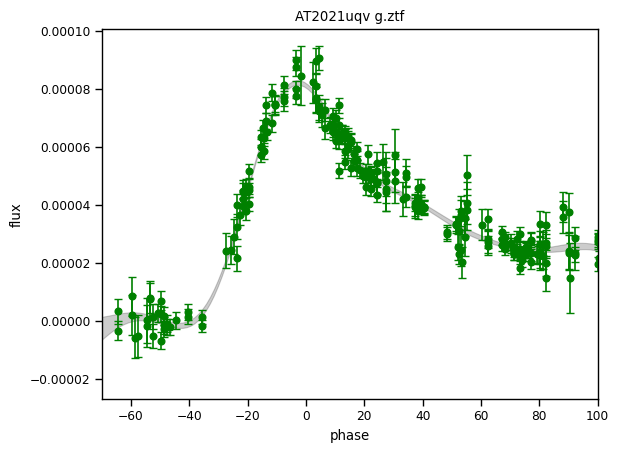

In [14]:
# Let's plot this

plt.errorbar(phases, fluxes, yerr=flux_errs, capsize=3, ls='none', marker = 'o', c = 'green')
plt.fill_between(phase_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2, zorder=1)
plt.xlabel('phase')
plt.ylabel('flux')
plt.title(tde_name + ' ' + filter_select)
plt.xlim(-70, 100)
plt.show()